# Imports

In [2]:
%load_ext autoreload
%autoreload 2

# og python libs
import re
import os
import pprint
import itertools
from typing import Tuple, List, Dict, Pattern, Any


# classic DS libs
import pandas as pd
import numpy as np

# viz libs
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from ipywidgets import interact, fixed, interact_manual

# scipy
from scipy.integrate import quad
from scipy.signal import find_peaks, peak_widths, find_peaks_cwt
from scipy.constants import k as k_B
from scipy.constants import c, pi, N_A, h, hbar, m_e, m_p

# lmfit things
from lmfit.models import LinearModel, GaussianModel, VoigtModel, SplineModel, ExponentialModel, ExpressionModel, Model, ConstantModel
from lmfit import Parameter, Parameters
from lmfit import minimize, minimizer

# ML
from sklearn.linear_model import LinearRegression

# GenAI
from google import genai
from google.genai import types

# natural data databases
import hapi
DB_PATH = 'hapi_data'
hapi.db_begin(DB_PATH)

# API setups
G_MODEL_ID = "gemini-2.5-flash-preview-05-20"
G_API_KEY = os.environ.get("GEMINI_API_KEY")
G_CLIENT = genai.Client(api_key=G_API_KEY)

response = G_CLIENT.models.generate_content(
    model=G_MODEL_ID,
    contents="test",
)

print(response.text)

pp = pprint.PrettyPrinter(depth=4)

HAPI version: 1.2.2.3
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

In [3]:
# custom
import sys
sys.path.append('../../../../../../')
from my_utils import defs as cp
from my_utils.classes import CEPAS_measurement, CEPAS_benchmark, CEPAS_noise_info, CEPAS_SNR_bench
cp.hello_test()

Hello!


# Benchmark

In [33]:
pressure_list = [300, 600, 900]
freq_list_2 = [30, 40, 80, 90, 130, 170, 220, 300]

benchmark_path_2 = "./"
benchmark_noise_2 = "./noise-tests/"

patterns = cp.create_regex_strings(pressure_list, freq_list_2)

test_bench_files = cp.dir_match_dict(benchmark_path_2, patterns) 
# pp.pprint(patterns)
# pp.pprint(test_bench_files)

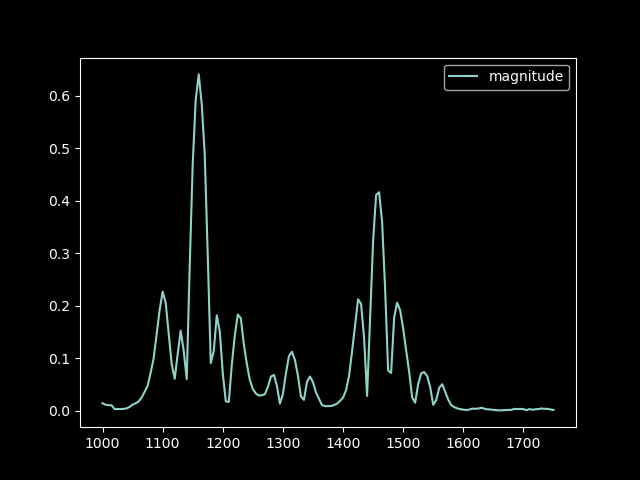

,time,offset1,P1,H3,H2,P_las,T_las,RH,Pressure,time_subtracted,H2_pnorm,H3_pnorm,wavenumbers,magnitude_pnorm
1,5352.029,1000.0,0.0,0.000383,-0.000147,0.025740,393.6961,27.12402,592.0,0.000,-0.005196,0.013578,6985.643439,0.014538
2,5354.026,1005.0,0.0,0.000210,-0.000150,0.025740,403.5192,27.12402,592.0,1.997,-0.005327,0.007419,6985.621618,0.009133
3,5355.910,1010.0,0.0,0.000285,-0.000148,0.025740,393.6961,27.14844,592.0,3.881,-0.005247,0.010081,6985.599798,0.011365
4,5357.893,1015.0,0.0,0.000091,-0.000041,0.034761,403.5192,27.12402,592.0,5.864,-0.001107,0.002435,6985.577977,0.002675
5,5359.891,1020.0,0.0,0.000112,-0.000013,0.025758,393.6961,27.14844,592.0,7.862,-0.000468,0.003950,6985.556157,0.003978


In [36]:


u1 = [1158.1, 1452.7]
u2 = [6984.9534710, 6983.6678]

# REMINDER frequencies: [20, 30, 40, 80, 90, 130, 170, 220, 300]
p = 600
f = 30
bench_test_2 = CEPAS_benchmark(benchmark_path_2, test_bench_files, p, f)
# bench_test.self_test()
bench_test_2.add_wav(u1, u2)
bench_test_2.add_magnitude()
test_avg = bench_test_2.get_avg()
target_peak = (1400, 1550)
bench_peaks = find_peaks_cwt(test_avg['H2_pnorm'], 10.0)
# print(bench_peaks)
# print(test_300_20)
%matplotlib widget

plt.close()
plt.figure()
# 1st test
# plt.plot(bench_test_2.spectra.spectra_list[0]['offset1'], bench_test_2.spectra.spectra_list[0]['H2_pnorm'])
# plt.plot(bench_test_2.spectra.spectra_list[1]['offset1'], bench_test_2.spectra.spectra_list[1]['H2_pnorm'])
# plt.plot(bench_test_2.spectra.spectra_list[2]['offset1'], bench_test_2.spectra.spectra_list[2]['H2_pnorm'])
# plt.plot(test_avg['offset1'][bench_peaks], test_avg['H2_pnorm'][bench_peaks], 'rx')
# plt.plot(test_avg['offset1'], test_avg['H2_pnorm'], label='avg')

# test magnitude
plt.plot(test_avg['offset1'], test_avg["magnitude_pnorm"], label="magnitude")

plt.legend()
# plt.xlim(1625, 1750)
# plt.ylim(-0.008, -0.0015)
plt.show()
bench_test_2.spectra.spectra_list[0].head()

# Signal

Uncomment below to see all the peaks used for bench

41    13.388988
Name: magnitude_pnorm, dtype: float64


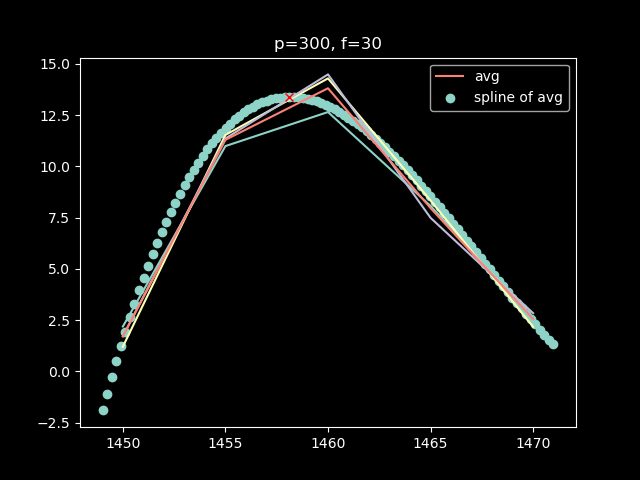

38    13.574229
Name: magnitude_pnorm, dtype: float64


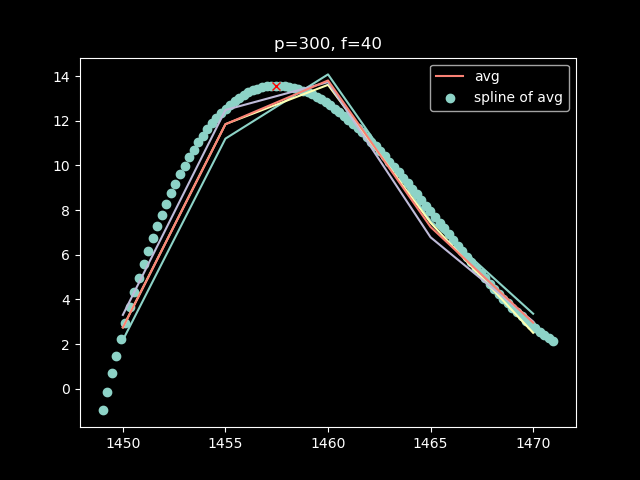

39    10.67778
Name: magnitude_pnorm, dtype: float64


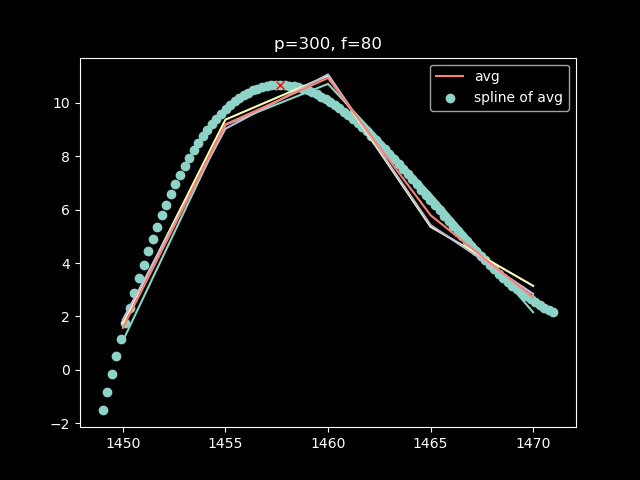

38    10.012614
Name: magnitude_pnorm, dtype: float64


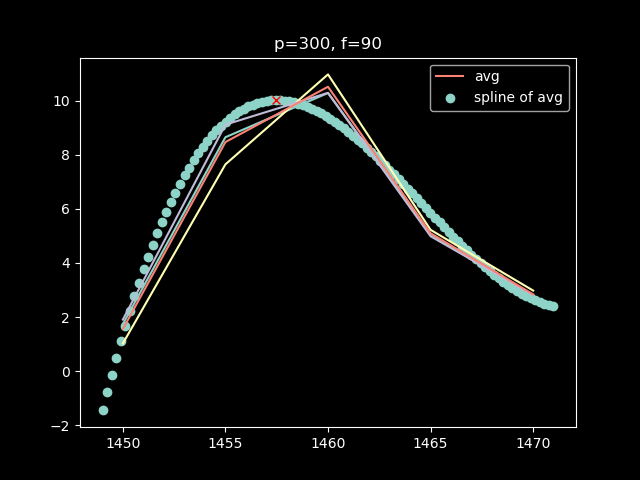

41    9.114213
Name: magnitude_pnorm, dtype: float64


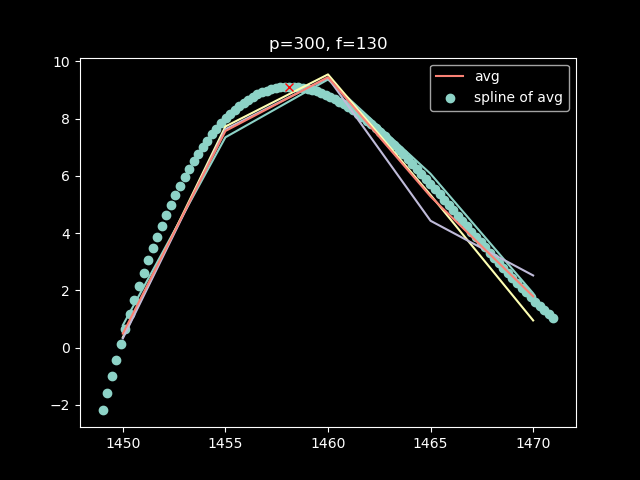

38    9.692345
Name: magnitude_pnorm, dtype: float64


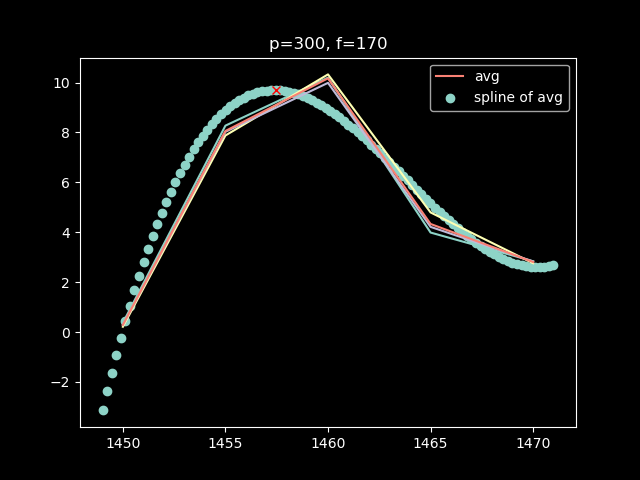

39    17.156893
Name: magnitude_pnorm, dtype: float64


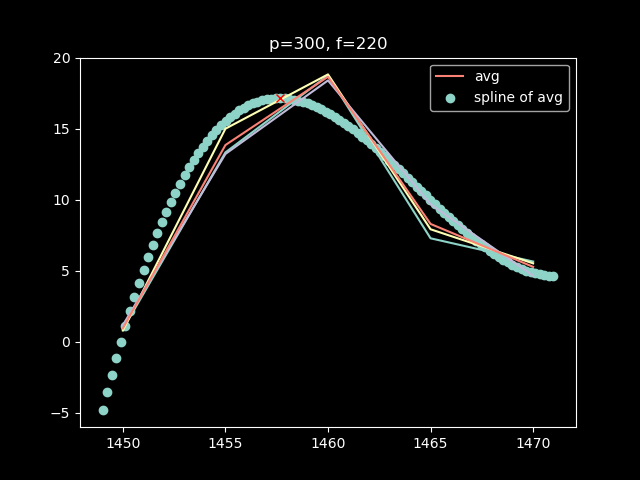

39    5.580231
Name: magnitude_pnorm, dtype: float64


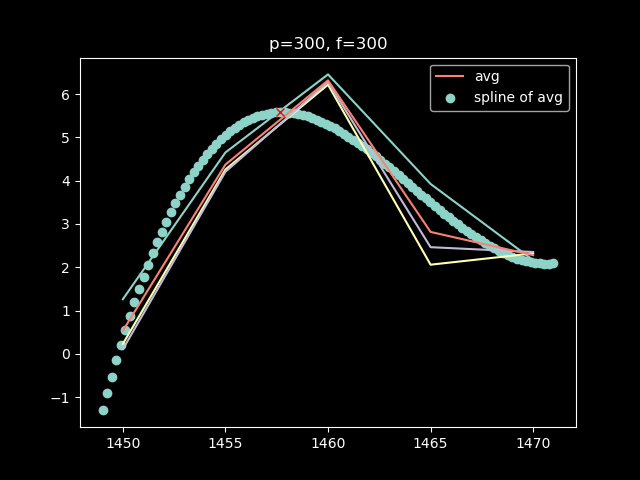

41    0.423952
Name: magnitude_pnorm, dtype: float64


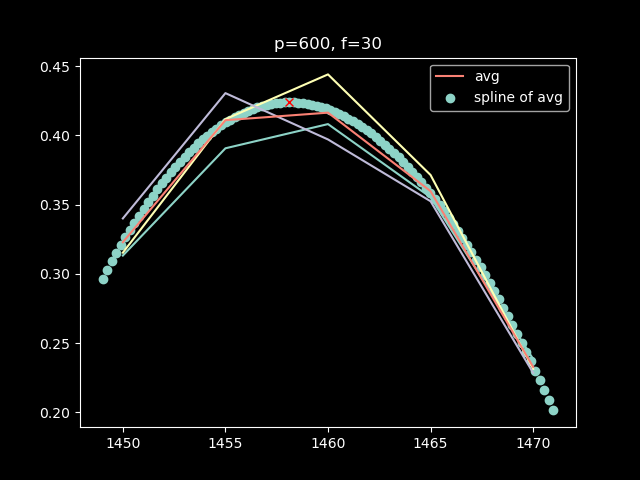

41    0.419162
Name: magnitude_pnorm, dtype: float64


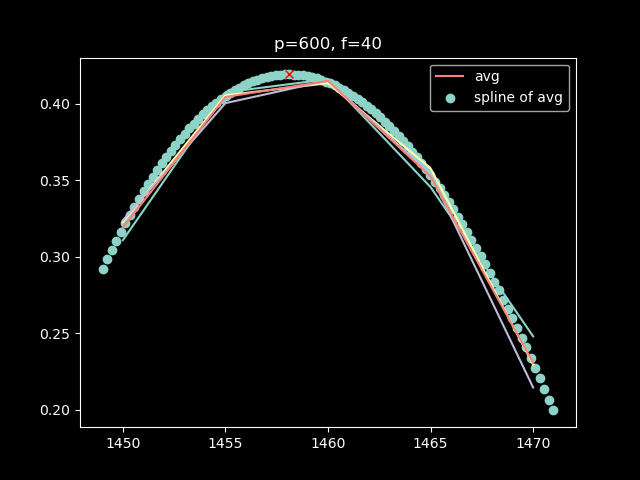

40    0.374733
Name: magnitude_pnorm, dtype: float64


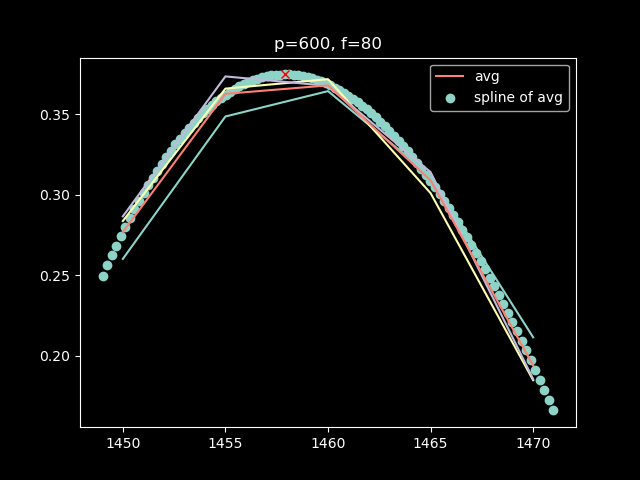

41    0.368094
Name: magnitude_pnorm, dtype: float64


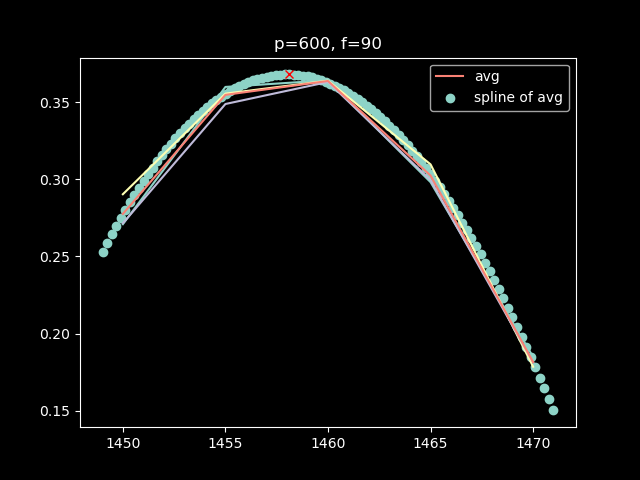

40    0.343126
Name: magnitude_pnorm, dtype: float64


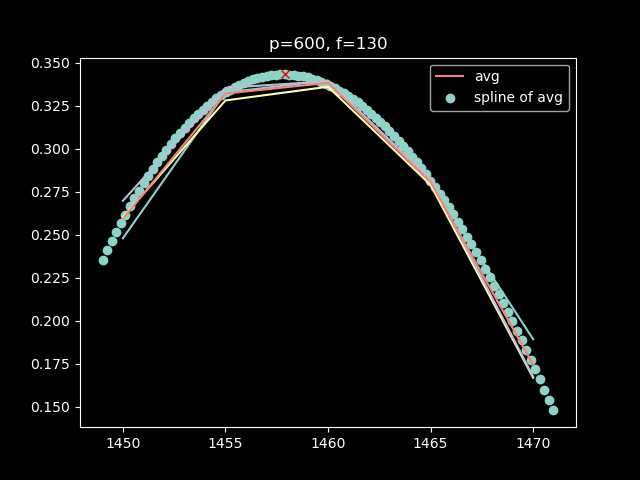

39    0.354569
Name: magnitude_pnorm, dtype: float64


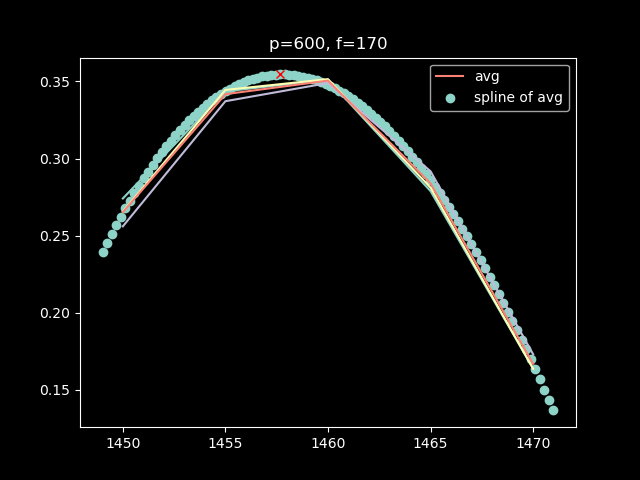

45    0.486152
Name: magnitude_pnorm, dtype: float64


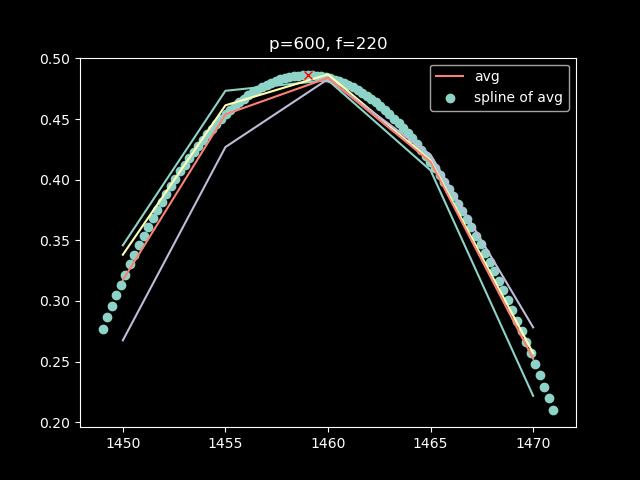

48    0.417388
Name: magnitude_pnorm, dtype: float64


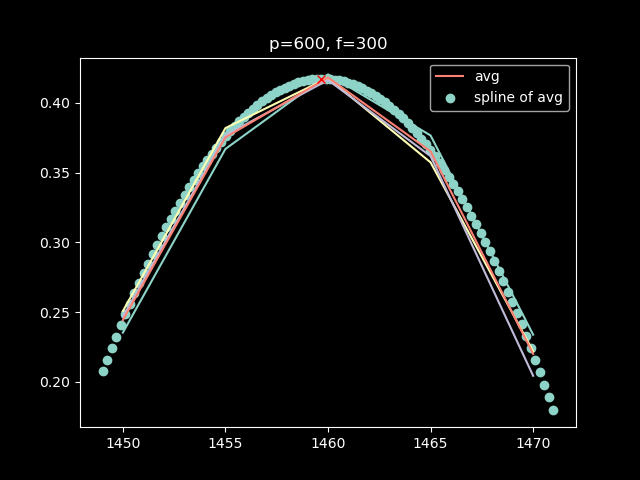

65    0.445651
Name: magnitude_pnorm, dtype: float64


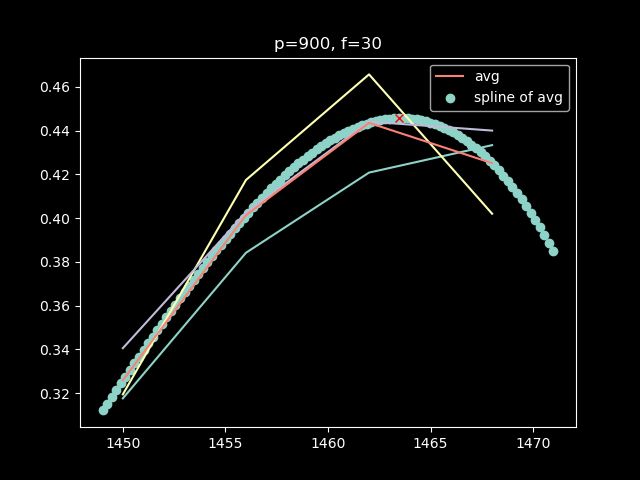

56    0.444279
Name: magnitude_pnorm, dtype: float64


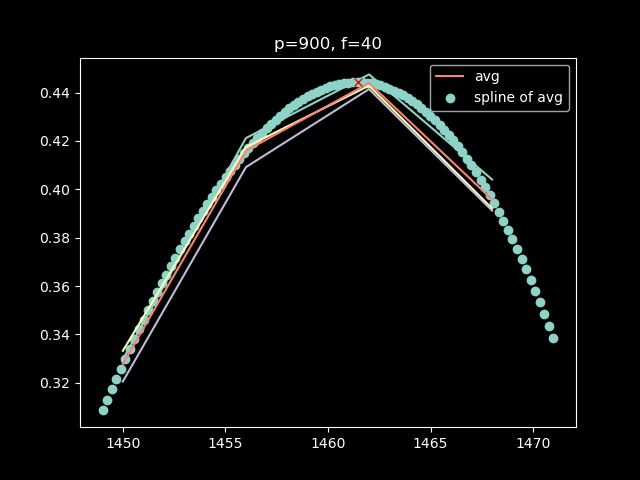

58    0.419255
Name: magnitude_pnorm, dtype: float64


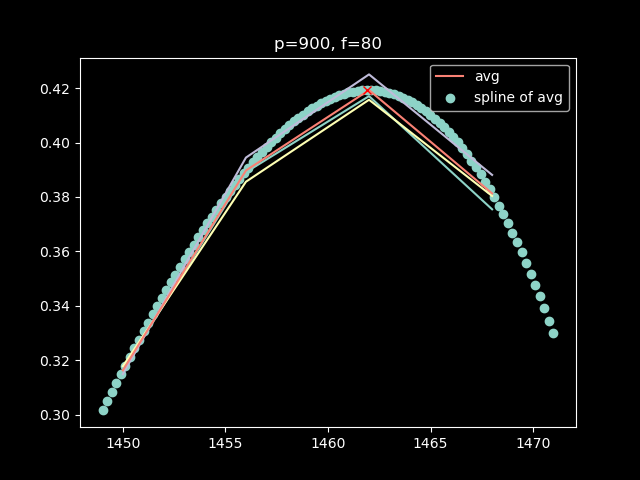

57    0.416118
Name: magnitude_pnorm, dtype: float64


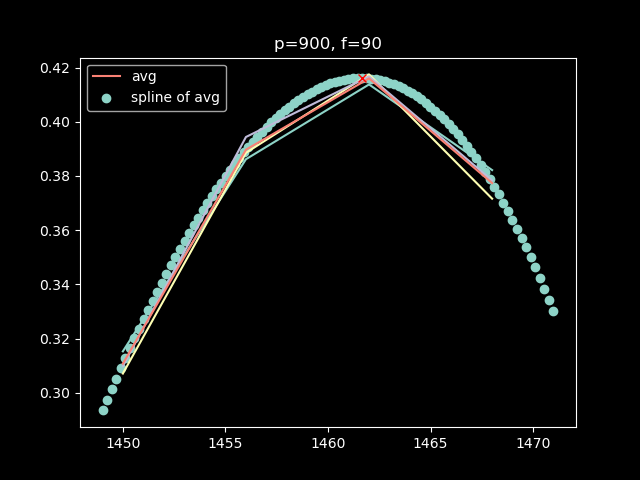

58    0.392618
Name: magnitude_pnorm, dtype: float64


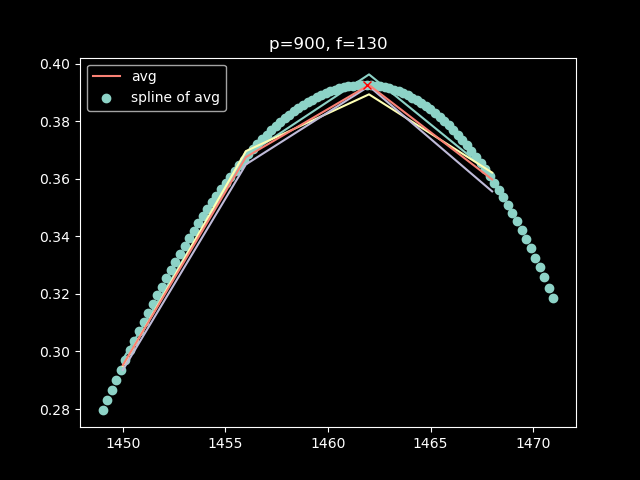

57    0.400895
Name: magnitude_pnorm, dtype: float64


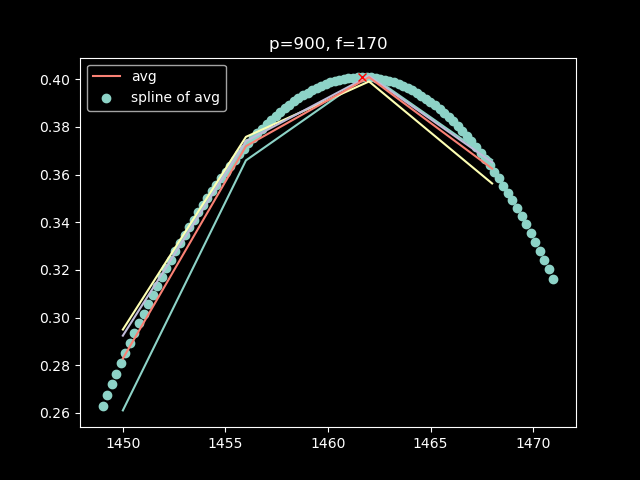

56    0.487105
Name: magnitude_pnorm, dtype: float64


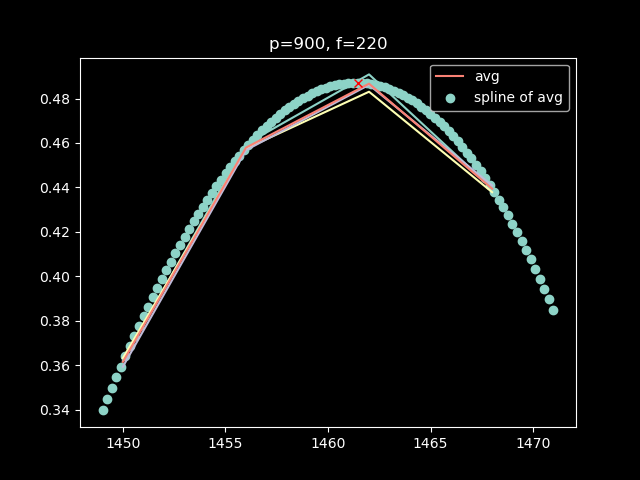

56    0.750464
Name: magnitude_pnorm, dtype: float64


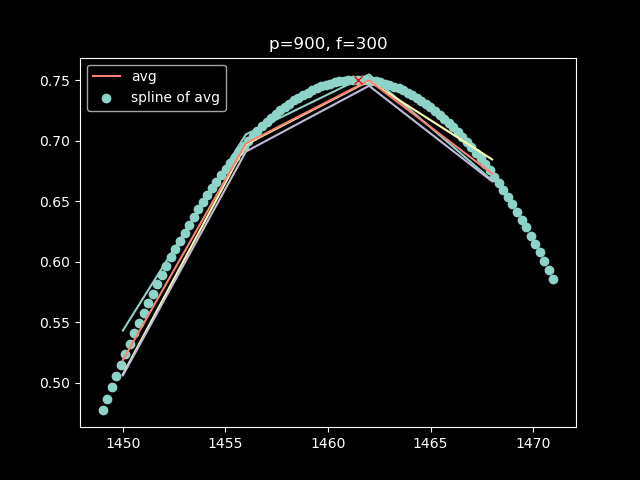

In [37]:
plt.close()
ps = [300, 600, 900]
fs = [30, 40, 80, 90, 130, 170, 220, 300]
for p, f in itertools.product(ps, fs):
    bench_test = CEPAS_benchmark(benchmark_path_2, test_bench_files, p, f)
    bench_test.add_magnitude()
    peak_start = 1449
    peak_end = 1471
    peak = bench_test.get_window(peak_start, peak_end)
    peak_spline = bench_test.get_spline_of_window(n_spectrum=-1,
                                                  n_knots=4,
                                                  colx="offset1",
                                                  coly="magnitude_pnorm",
                                                  start=peak_start,
                                                  end=peak_end)
    # print(peak_spline[1])
    print(peak_spline[-1])
    plt.figure()
    plt.plot(peak[0]['offset1'], peak[0]['magnitude_pnorm'])
    plt.plot(peak[1]['offset1'], peak[1]["magnitude_pnorm"])
    plt.plot(peak[2]['offset1'], peak[2]["magnitude_pnorm"])
    plt.plot(peak[3]['offset1'], peak[3]['magnitude_pnorm'], label='avg')
    plt.scatter(peak_spline[2]['offset1'], peak_spline[2]['magnitude_pnorm'], label='spline of avg')
    plt.plot(peak_spline[-2]['offset1'], peak_spline[-2]['magnitude_pnorm'], 'rx')
    plt.legend()
    plt.title(f"p={p}, f={f}")
    plt.show()

# Noise

5.443e-05


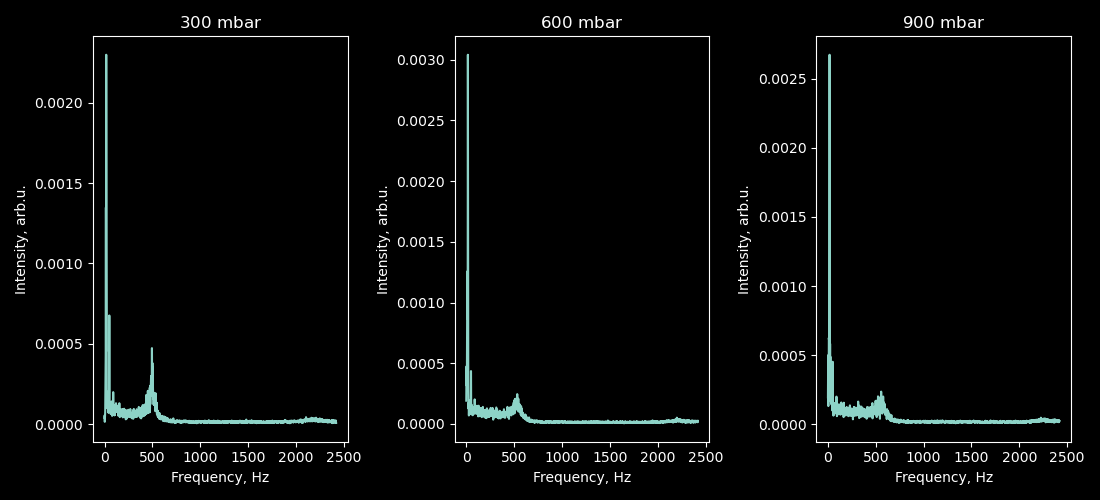

In [38]:
bench_noise_300_2 = CEPAS_noise_info(benchmark_noise_2, 300)
bench_noise_600_2 = CEPAS_noise_info(benchmark_noise_2, 600)
bench_noise_900_2 = CEPAS_noise_info(benchmark_noise_2, 900)


print(f"{np.format_float_scientific(bench_noise_300_2.get_noise_at(f), precision=3)}")
plt.close()
plt.figure(figsize=(11, 5))
plt.subplot(131)
plt.title("$300\\ \\text{mbar}$")
plt.xlabel('Frequency, Hz')
plt.ylabel('Intensity, arb.u.')
plt.plot(bench_noise_300_2.spectrum['freq'], bench_noise_300_2.spectrum['intensity'])
plt.subplot(132)
plt.title("$600\\ \\text{mbar}$")
plt.xlabel('Frequency, Hz')
plt.ylabel('Intensity, arb.u.')
plt.plot(bench_noise_600_2.spectrum['freq'], bench_noise_600_2.spectrum['intensity'])
plt.subplot(133)
plt.title("$900\\ \\text{mbar}$")
plt.xlabel('Frequency, Hz')
plt.ylabel('Intensity, arb.u.')
plt.plot(bench_noise_900_2.spectrum['freq'], bench_noise_900_2.spectrum['intensity'])
plt.tight_layout()
plt.show()

In [40]:
noise_start_2 = 1625
noise_end_2 = 1749
peak_start_2 = 1440
peak_end_2 = 1480
bench_final_2 = CEPAS_SNR_bench(
    test_bench_files,
    bench_path=benchmark_path_2,
    noise_path=benchmark_noise_2,
    file_sig="single")
get_all_2 = bench_final_2.get_all_snrs(
    [peak_start_2, noise_start_2],
    [peak_end_2, noise_end_2],
    n_knots=6) # float=1625, end: int | float=1750
df_snr_2 = get_all_2[0]
df_noise_2 = get_all_2[1]

DEBUG: At p=300                         and f=30 signal is 
---->48    6.736931
Name: H2_pnorm, dtype: float64<----

noise from single measurements: 7.220563868837082e-05
DEBUG: At p=300                         and f=40 signal is 
---->46    8.212956
Name: H2_pnorm, dtype: float64<----

noise from single measurements: 4.398905821967013e-05
DEBUG: At p=300                         and f=80 signal is 
---->46    9.303131
Name: H2_pnorm, dtype: float64<----

noise from single measurements: 3.4020491488381334e-05
DEBUG: At p=300                         and f=90 signal is 
---->46    8.904873
Name: H2_pnorm, dtype: float64<----

noise from single measurements: 4.513317621631518e-05
DEBUG: At p=300                         and f=130 signal is 
---->47    8.877569
Name: H2_pnorm, dtype: float64<----

noise from single measurements: 3.1799734905572254e-05
DEBUG: At p=300                         and f=170 signal is 
---->45    9.948715
Name: H2_pnorm, dtype: float64<----

noise from single measur

IndexError: single positional indexer is out-of-bounds